## Evaluate the S+Leaf kernel on the full signal over a range of gap sizes

- Use S+Leaf
- Pulsation + noise (S+Leaf does not work on the Eclipsing Binary signal !!)
- Soho kernel(s)
- Predefined gap timestamps
- Multiple gap sizes

In [1]:
import os
import sys
import math
%load_ext autoreload
%autoreload 2

import numpy as np
np.random.seed(0)

# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from astropy.timeseries import LombScargle
import pandas as pd
pd.set_option('precision', 0)
pd.set_option('display.float_format', lambda x: '%.16f' % x)

from spleaf import cov, term
from scipy.optimize import fmin_l_bfgs_b

# Start the notebook from the root of the project
if 'notebooks' in os.getcwd():
    os.chdir(os.path.dirname(os.getcwd()))
    if os.getcwd().endswith('notebooks'):
        os.chdir(os.path.dirname(os.getcwd()))

 # Local imports (i.e., my code) from the src folder
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))

from plot_helpers import *
plotter = PlotUtilSPLeaf()

Read the first time series

In [2]:
# Make the notebook use the whole screen width
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [3]:
df = pd.read_csv("./data/sim_noisy_pulse.lc",sep=' ', header = None, names=['Time', 'Lc'], index_col=False, float_precision='round_trip')
df.dtypes

Time    float64
Lc      float64
dtype: object

In [4]:
X, Y = df['Time'].tolist(), df['Lc'].tolist()
X, Y = np.array(X), np.array(Y)

# 1. Exploratory
Plot the data

Zoomed in on the first N observations

In [5]:
# 11300 is the complete first envelope
N_part=11300

In [6]:
X_part=X[:N_part]
Y_part=Y[:N_part]

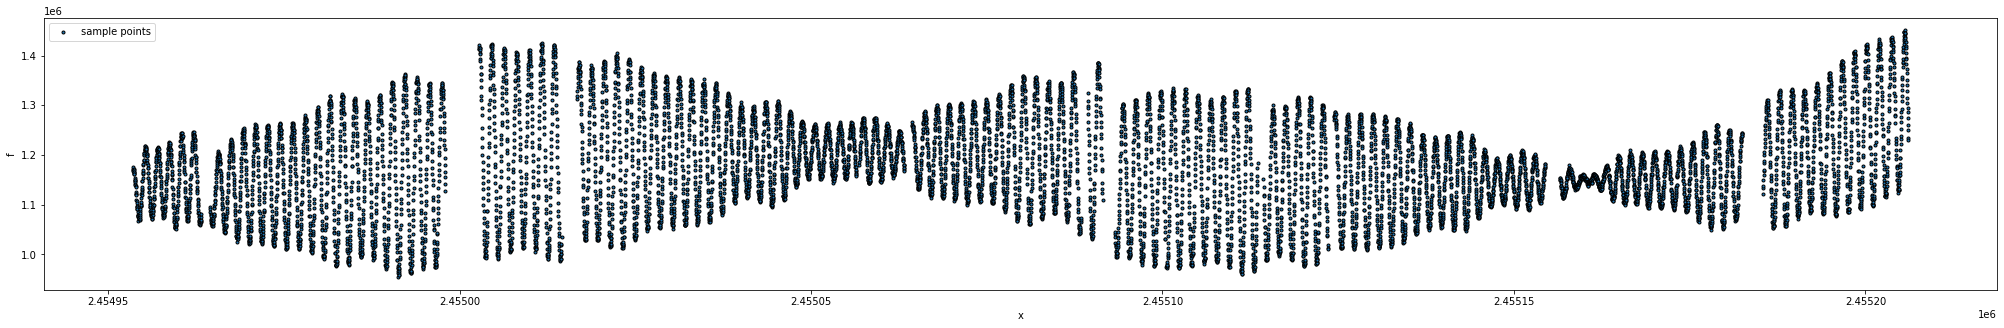

In [7]:
plotter.plot_data(X_part, Y_part)

# 2. Processing


Fit a simple smoothing kernel to the signal

In [8]:
# normalize the data
mean, std = Y_part.mean(),Y_part.std()
Y_part = (Y_part - mean) / std

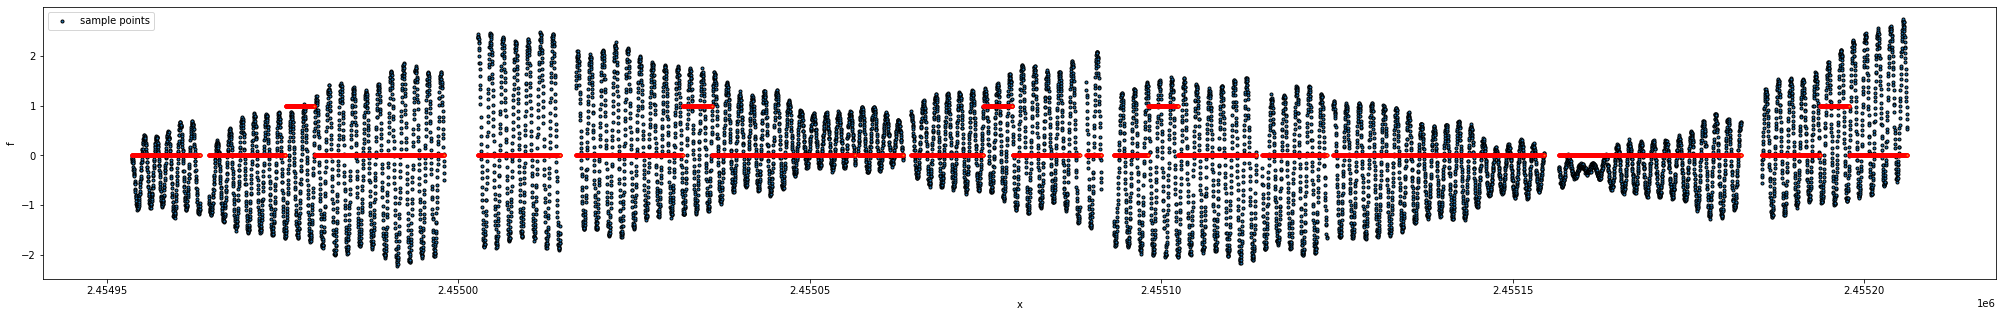

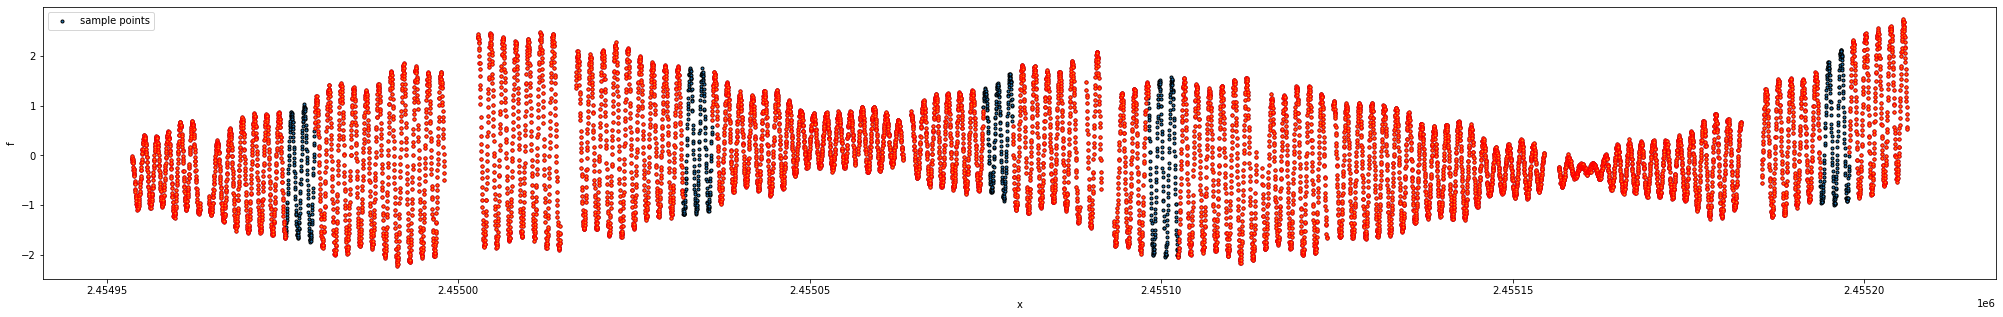

In [9]:
# Introduce gaps in the data
gap_idcs = [1100, 3500, 5500, 6500, 10800]
gap_size = 200

# Define the masks where will introduce the gaps
Y_mask = np.zeros(X_part.shape)
for idx in gap_idcs:
    Y_mask[int(idx-gap_size/2):int(idx+gap_size/2)] = 1

# Now store the timestamps of this gaps for our fitting procedure
X_gaps = X_part[Y_mask==1]

# And remove the observations at the gaps from X and Y
X_without_gaps = X_part[Y_mask==0]
Y_without_gaps = Y_part[Y_mask==0]

plotter.plot_data(X_part, Y_part, X_part, Y_mask)
plotter.plot_data(X_part, Y_part, X_without_gaps, Y_without_gaps)

In [10]:
# Define the function to minimize
def negloglike(x, y, cov_matrix, params_to_fit):
   cov_matrix.set_param(x, params_to_fit)
   nll = -cov_matrix.loglike(y)
   # gradient
   nll_grad = -cov_matrix.loglike_grad()[1]
   return(nll, nll_grad)

In [11]:
# Initialize the S+LEAF model

# Two stochastically-driven harmonic oscillator
# One Uncorrelated measurement errors (yerr)
# Calibration errors (correlated noise)
calib_id = (X_without_gaps//1).astype(int) # One calibration per day
caliberr = np.random.uniform(0.5, 1.5, calib_id[-1]+1)
yerr_calib = caliberr[calib_id]

cov_matrix = cov.Cov(X_without_gaps,
   err = term.Error(1),
   sho = term.SHOKernel(sig=-0.04314, P0=1.7474, Q=8019.36505),
   sho2 = term.SHOKernel(sig=-0.04314, P0=1.0, Q=8019.36505),
   calerr=term.CalibrationError(calib_id, yerr_calib))

In [12]:
# List of parameters to fit: all (for now)
params_to_fit = cov_matrix.param

# We now fit the hyperparameters using the fmin_l_bfgs_b function from scipy.optimize.
xbest,_,_ = fmin_l_bfgs_b(negloglike, cov_matrix.get_param(), args=(Y_without_gaps, cov_matrix, params_to_fit))

In [13]:
xbest

array([-3.76446522e+00,  1.77076006e+00,  8.01936493e+03,  1.43542955e-06,
        1.49631985e+00,  8.01936505e+03])

In [14]:
# We now use S+LEAF to predict the missing data on the training data scope
cov_matrix.set_param(xbest, params_to_fit)
Y_pred_gaps, var_pred_gaps = cov_matrix.conditional(Y_without_gaps, X_part, calc_cov='diag')

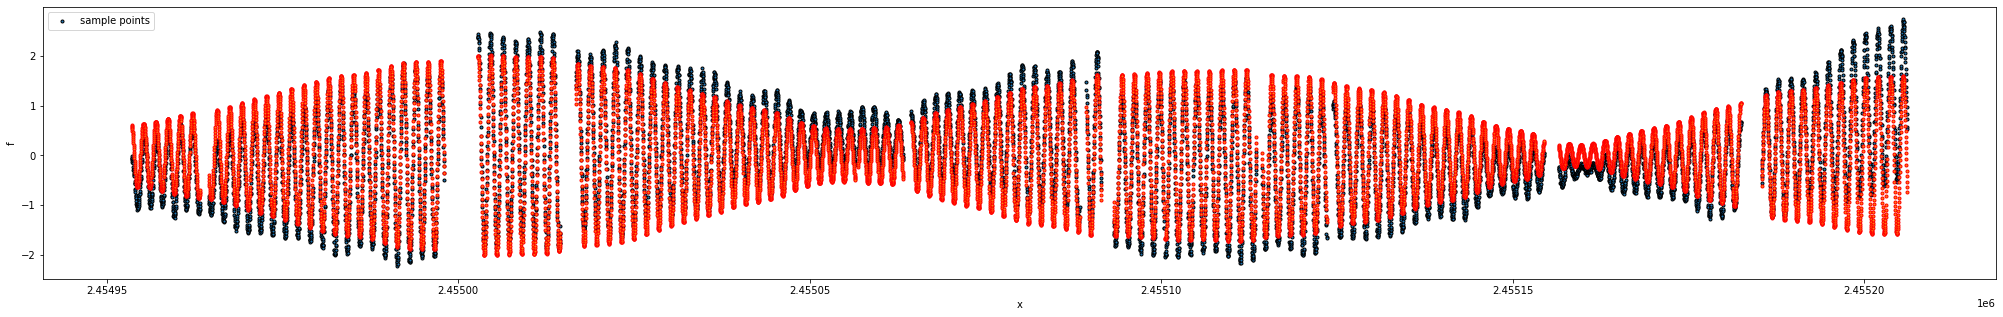

In [15]:
plotter.plot_data(X_part, Y_part, X_part, Y_pred_gaps)

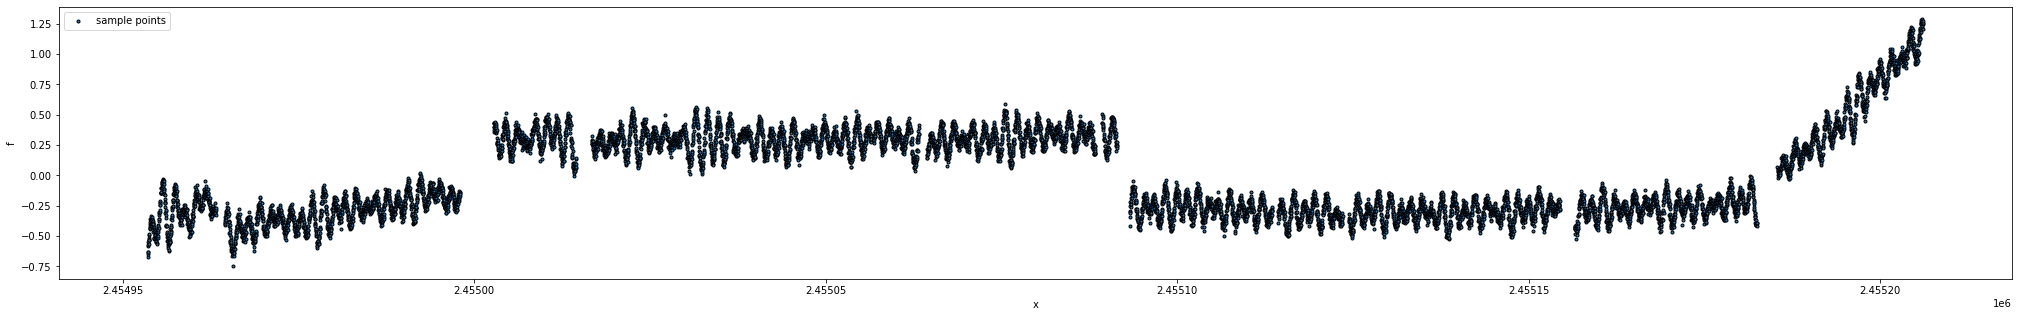

In [16]:
# Calculate the residuals on the original X positions!
residuals = Y_part-Y_pred_gaps
plotter.plot_data(X_part, residuals)

# Correlation between the original data and the fitted data

In [17]:
ts_orig = pd.DataFrame()
ts_orig['signal'] = Y_part
ts_fitted = pd.DataFrame()
ts_fitted['signal'] = Y_pred_gaps

In [18]:
ts_orig.corrwith(ts_fitted)

signal   0.9346681456585278
dtype: float64